In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [107]:
# Let's load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

columns = ['persoon_leeftijd_bij_onderzoek', 'persoonlijke_eigenschappen_dagen_sinds_taaleis',
  'ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden', 'relatie_kind_huidige_aantal',
  'persoon_geslacht_vrouw', 'belemmering_dagen_psychische_problemen',
    'persoonlijke_eigenschappen_taaleis_voldaan', 'belemmering_dagen_lichamelijke_problematiek',
      'relatie_kind_tiener', 'competentie_vakdeskundigheid_toepassen',
        'relatie_kind_leeftijd_verschil_ouder_eerste_kind', 'beschikbaarheid_aantal_historie_afwijkend_wegens_medische_omstandigheden',
          'relatie_kind_jongvolwassen', 'afspraak_afgelopen_jaar_ontheffing_taaleis',
            'belemmering_hist_verslavingsproblematiek', 'belemmering_financiele_problemen',
              'relatie_partner_huidige_partner___partner__gehuwd_', 'relatie_partner_totaal_dagen_partner',
                'belemmering_dagen_financiele_problemen', 'ontheffing_dagen_hist_mean']

# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked'], axis=1)
X = X[columns]
X = X.astype(np.float32)


# Let's load the model
new_session = rt.InferenceSession("model/model1.onnx")

inputs = {}

for i in columns:
    inputs[i] = X[i].values.astype(np.float32).reshape(12645, 1)

y_pred_onnx2 =  new_session.run(None, inputs)

accuracy_onnx_model = accuracy_score(y, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


Accuracy of the ONNX model:  0.9159351522340846


268
Accuracy:  0.9159351522340846
F1 Score:  0.3065883887801696
Recall:  0.1857707509881423
Precision:  0.8768656716417911


C:\Users\Dell\AppData\Local\Temp\ipykernel_7732\3726854716.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  fp = i[0][2]/i[1][2]


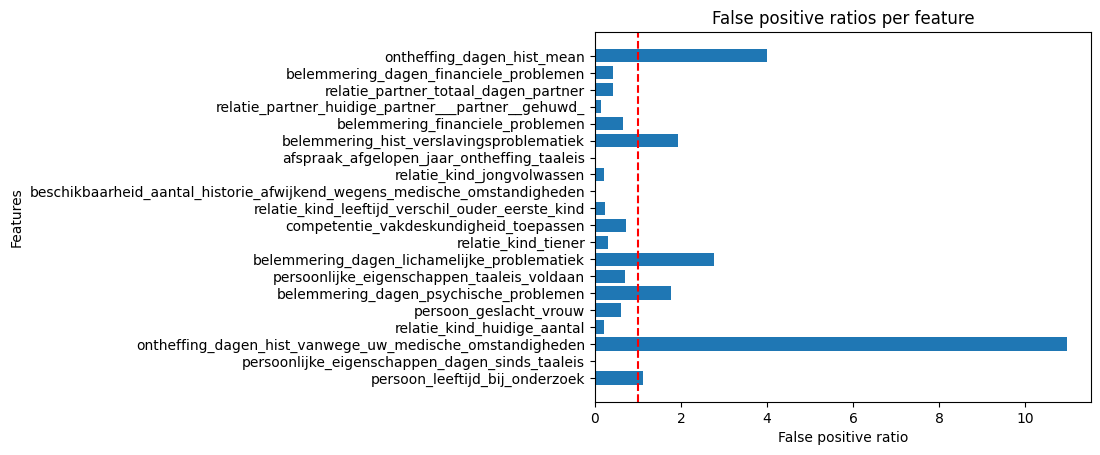

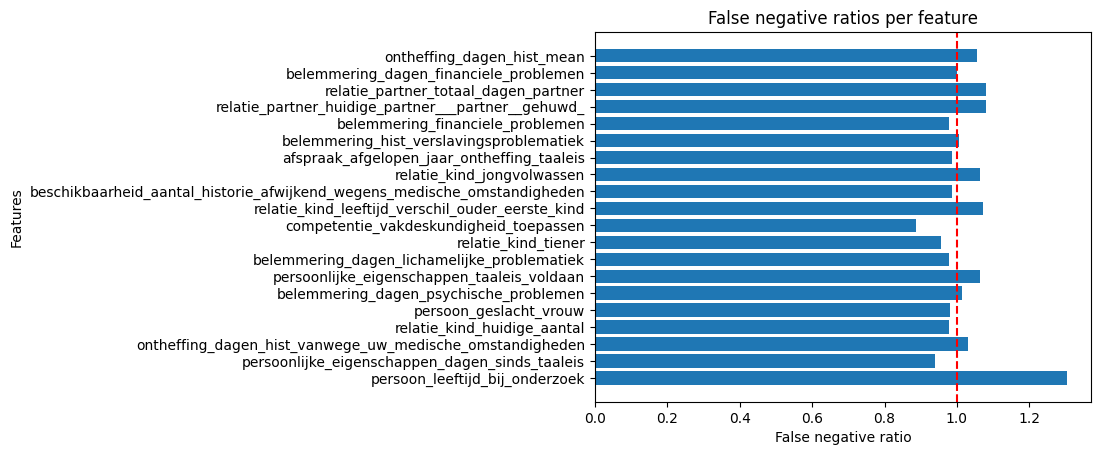

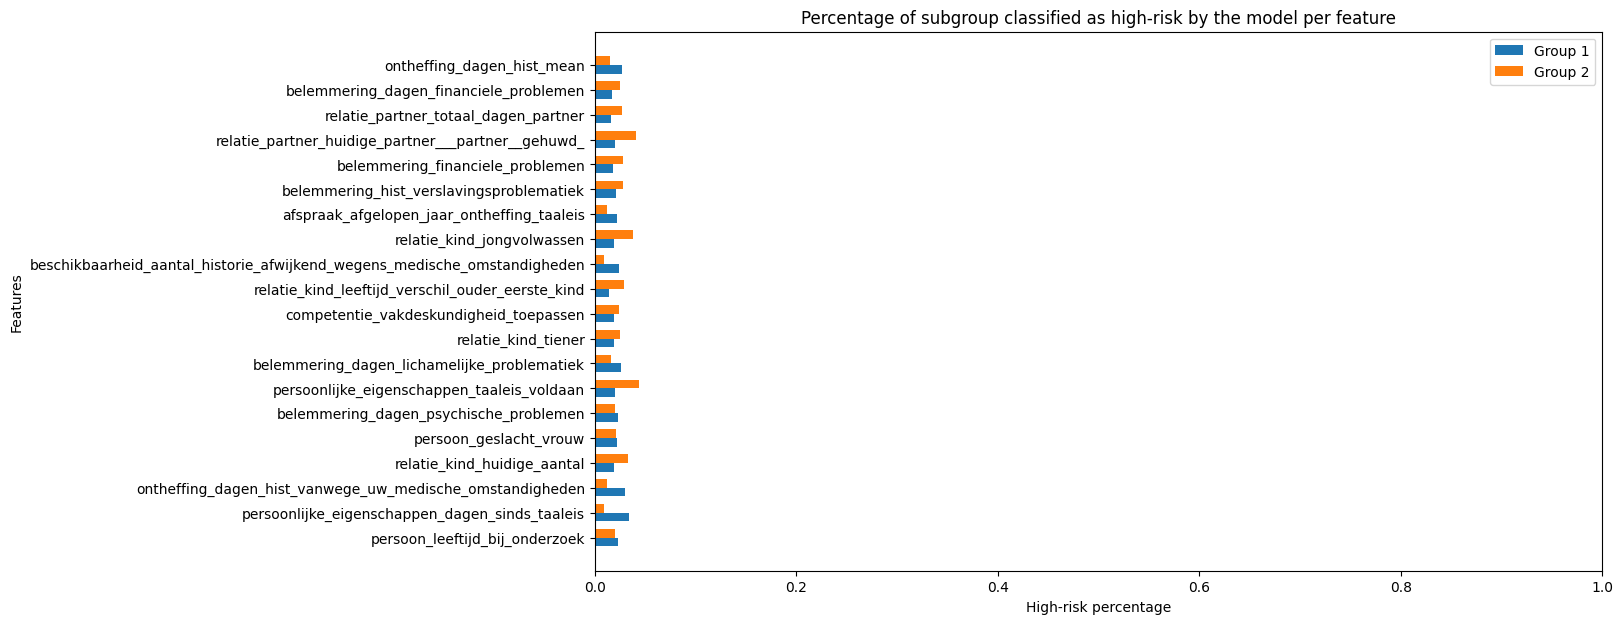

In [110]:

# Test 3: Using standard metrics such as false positive/negative ratio and plotting bar charts


# Selecting sensitive features from dataset
selected_features = pd.DataFrame()

features = []
for i in columns:
    if X[i].max() == 1.0:
        selected_features[i] = [1 if r== 1 else 0 for r in X[i]]
        features.append(i)
    else:
        middle = X[i].median()
        selected_features[i] = [1 if r>(middle) else 0 for r in X[i]]
        features.append(i)

selected_features['privChecked'] =  [1 if v == 1 else 0 for v in y]

# Running the model on test set and adding the result to selected_features
yPred = y_pred_onnx2[0]
selected_features['yPred'] = yPred

print(yPred.sum()/len(yPred))

#Calculating metrics
acc = accuracy_score(y, yPred)
f1Score = f1_score(y, yPred)
recallScore = recall_score(y, yPred)
precScore = precision_score(y, yPred)

print("Accuracy: ", acc)
print("F1 Score: ", f1Score)
print("Recall: ", recallScore)
print("Precision: ", precScore)


#Calculates metrics for a given dataset
def fairRatio(data):
    """Calculate fairness for subgroup of population"""
    
    #Confusion Matrix
    cm=confusion_matrix(data['privChecked'],data['yPred'])
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN #Total population
    ACC = (TP+TN)/N #Accuracy
    TPR = TP/(TP+FN) # True positive rate
    FPR = FP/(FP+TN) # False positive rate
    FNR = FN/(TP+FN) # False negative rate
    PPP = (TP + FP)/N # % predicted as positive
    
    return np.array([ACC, TPR, FPR, FNR, PPP])

# Calculating ratios per sensitive features and saving the results

ratios = []

for i in features:
    if i == 'privChecked':
        continue
    ratio_1 = fairRatio(selected_features[selected_features[i] == 0])
    ratio_2 = fairRatio(selected_features[selected_features[i] == 1])
    ratios.append([ratio_1, ratio_2])

fp_ratios = []
fn_ratios = []
group1_positive = []
group2_positive = []

for i in ratios:
    fp = i[0][2]/i[1][2]
    fn = i[0][3]/i[1][3]
    fp_ratios.append(fp)
    fn_ratios.append(fn)
    group1_positive.append(i[0][4])
    group2_positive.append(i[1][4])


# Plot 1 
plt.barh(features, fp_ratios)

plt.ylabel("Features")
plt.xlabel("False positive ratio") 
plt.title("False positive ratios per feature")
plt.axvline(x=1, color='r', linestyle='--', label=f'Threshold at {1}')
plt.show()


# Plot 2
plt.barh(features, fn_ratios)

plt.ylabel("Features")
plt.xlabel("False negative ratio") 
plt.title("False negative ratios per feature")
plt.axvline(x=1, color='r', linestyle='--', label=f'Threshold at {1}')
plt.show()


# Plot 3
import numpy as np
import matplotlib.pyplot as plt

# Assuming the rest of your code is unchanged and `features`, `group1_positive`, and `group2_positive` are defined

# Plot 3 setup
pos = np.arange(len(features))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(13, 7))  # Adjusted for readability; change as needed
bar_group1 = ax.barh(pos - bar_width/2, group1_positive, bar_width, label='Group 1')
bar_group2 = ax.barh(pos + bar_width/2, group2_positive, bar_width, label='Group 2')

# Setting axis labels and title
ax.set_xlabel('High-risk percentage')
ax.set_ylabel('Features')
ax.set_title('Percentage of subgroup classified as high-risk by the model per feature')

# Setting y-axis ticks
ax.set_yticks(pos)
ax.set_yticklabels(features)

# Setting the x-axis scale from 0 to 1
ax.set_xlim(0, 1)

# Adding a legend
ax.legend()

# Display the plot
plt.show()


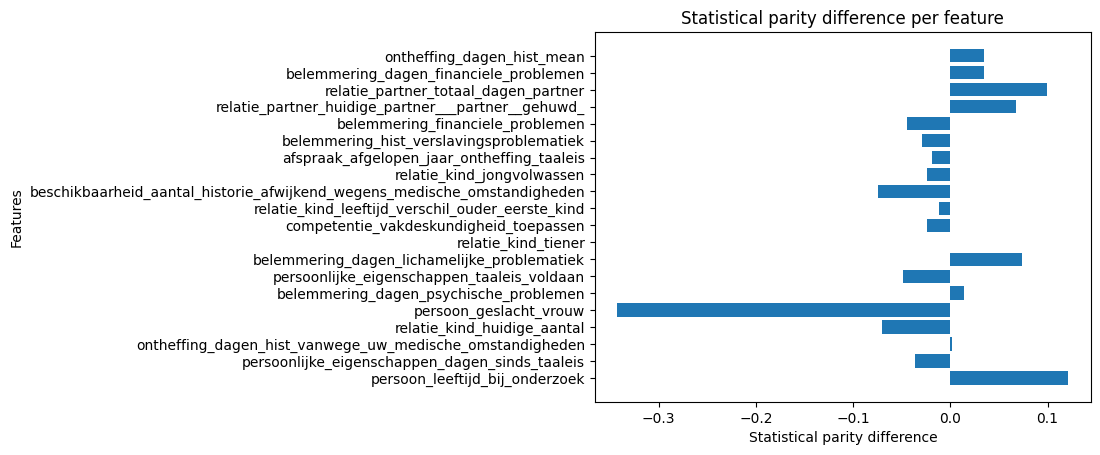

In [100]:
# Statistical parity difference (if negative, it means that it is biased towards the priviledged group)
spd = []

for i in ratios:
    spd.append(i[0][1]-i[1][1])

plt.barh(features, spd)
 
# setting label of y-axis
plt.ylabel("Features")
 
# setting label of x-axis
plt.xlabel("Statistical parity difference") 
plt.title("Statistical parity difference per feature")
plt.show()

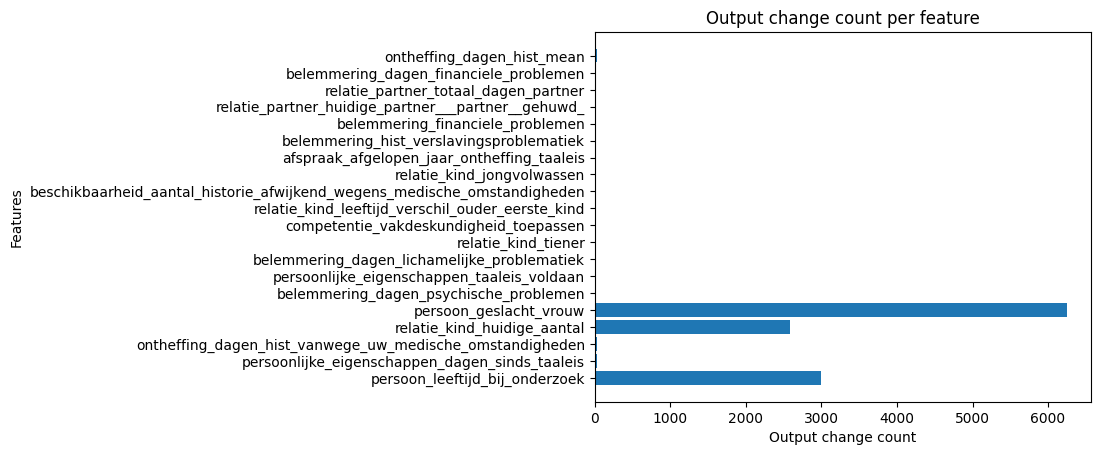

In [101]:
# Test 5: Metamorphic testing: We take the test set, modify sensitive features, run the model. Then we compare results with the original unmodified version. 
# Since all other features are same except modified sensitive feature, ideally output should be identical.

# Function to change numerical features
def change_numerical_feature(X_set, name_feature):
    max_days = X_set[name_feature].max()
    min_days = X_set[name_feature].min()

    # We change the ages using the formula A_new = A_max + A_min - A_current
    return X_set[name_feature].apply(lambda x: max_days + min_days - x)


# Function for counting difference between model predictions (for mutated vs. original data)
def count_difference(data):
    inputs = {}

    for i in columns:
        inputs[i] = data[i].values.astype(np.float32).reshape(12645,1)

    y_new =  new_session.run(None, inputs)

    differences = (y_new[0] != y_pred_onnx2[0]).sum().sum()

    output_change_count.append(differences)

output_change_count = []

for i in columns:
    X_test_feature_changed = X.copy()
    X_test_feature_changed[i] = change_numerical_feature(X_test_feature_changed, i)
    count_difference(X_test_feature_changed)

plt.barh(columns, output_change_count)
 
# setting label of y-axis
plt.ylabel("Features")
 
# setting label of x-axis
plt.xlabel("Output change count") 
plt.title("Output change count per feature")
plt.show()